In [59]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from scipy.integrate import solve_ivp
import scipy.optimize as sc_opt
import math
from scipy.integrate import quad
import time
from IPython.core.debugger import set_trace
import datetime as dt

from numpy import genfromtxt

import sys
sys.path.append('../../models')
from models import firstordermodel, secondordermodel, thirdordermodel

sys.path.append('../')
from tools import stochasticSimulation, derive_regimes, discrete_ivp_solver, \
                    smooth_dap, sol_ivp_wrapper, smooth_regime, cost, sigmoid,\
                    simulate_MPC, mergeSwitchCont,sol_ivp_wrapper_discrete,\
                    build_initial_ipopt_object,\
                    consMatrix, plotSwitches, constraintASparse


from objective_functions import obj_rk


import scipy

%load_ext autoreload
%autoreload 2

# PATHS
FIGS = '/Users/madsobdrup/Dropbox/Skole/DTU/Studie/MASTER/THESIS/FIGS'

# Switching time optimization modules
import switching_times_1st as st1
import switching_times_2nd as st2

import lxml

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prices

In [2]:
regulation = pd.read_csv('../../data/realtimemarket.csv',header=0, index_col=0,skiprows = 0)
regulation = regulation.loc[regulation['PriceArea'] == 'DK1']
regulation = regulation[{'BalancingPowerPriceDownEUR','BalancingPowerPriceUpEUR'}]
regulation.index = pd.to_datetime(regulation.index)
regulation = regulation.reindex(index=regulation.index[::-1])

In [3]:
spot = pd.read_csv('../../data/elspotprices.csv',header=0, index_col=0,skiprows = 0)
spot = spot.loc[spot['PriceArea'] == 'DK1']
spot = spot[{'SpotPriceEUR'}]
spot.index = pd.to_datetime(spot.index)
spot = spot.reindex(index=spot.index[::-1])

In [4]:
prices = pd.concat([spot, regulation], axis=1, join='inner')
prices.columns = ['spot', 'up', 'down']
#prices = prices * 1e-6


# Make correct round off
num_deci = 2
prices_og = prices
prices = np.round(np.round(prices_og * 10**num_deci,num_deci) / 10**num_deci,num_deci) #= np.round(prices,3)

In [5]:
# Derive markets
tol = 1e-2

prices['market_spot'] = 0
prices['market_down'] = 0
prices['market_up'] = 0

# When both up and down is less than tol away from the spot price
prices.loc[(np.abs(np.round(prices['spot'] - prices['down'],2)) <= tol) & (np.abs(np.round(prices['spot'] - prices['up'],2)) <= tol),'market_spot'] = 1

# When both are different, but even the smallest is bigger than 0.1 we have an error. Put it to spot market
prices.loc[np.minimum(np.abs(prices['spot'] - prices['up']),np.abs(prices['spot'] - prices['down'])) > 0.1,'market_spot'] = 1


prices.loc[(prices['market_spot'] != 1) & (np.abs(np.round(prices['spot'] - prices['down'],2)) > np.abs(np.round(prices['spot'] - prices['up'],2))),'market_down'] = 1
prices.loc[(prices['market_spot'] != 1) & (np.abs(np.round(prices['spot'] - prices['down'],2)) <= np.abs(np.round(prices['spot'] - prices['up'],2))),'market_up'] = 1

prices['RK'] = prices['spot'] * prices['market_spot'] + prices['up'] * prices['market_up'] + prices['down'] * prices['market_down']
prices['RK'] 


frac_down = np.mean(prices['market_down'])
frac_spot = np.mean(prices['market_spot'])
frac_up = np.mean(prices['market_up'])

[frac_down, frac_spot, frac_up], np.sum([frac_down, frac_spot, frac_up])

([0.2864390060594673, 0.2907839729437738, 0.4227770209967589], 1.0)

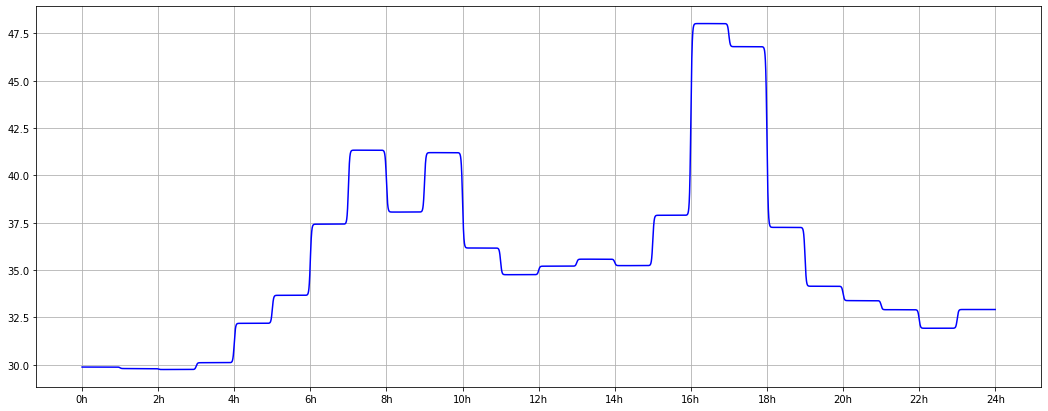

In [6]:
prices_plot = prices['2018-02-02  00:00:00':'2018-02-02  23:00:00']
T_price = 0.1 * np.arange(1,prices_plot.shape[0] * 60/0.1)
day_skip = 2
fig = plt.figure(figsize=(18,7))    
ax = fig.add_subplot(111)
ax.plot(T_price,smooth_dap(T_price,prices_plot['spot']),color='b')
ax.set_xticks(np.arange(0,prices_plot['spot'].size+1,day_skip)*60.)
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,prices_plot['spot'].size+1,day_skip) * 60.])
ax.grid()
#plt.savefig(FIGS + '/control/example_dap.pdf',format='pdf')

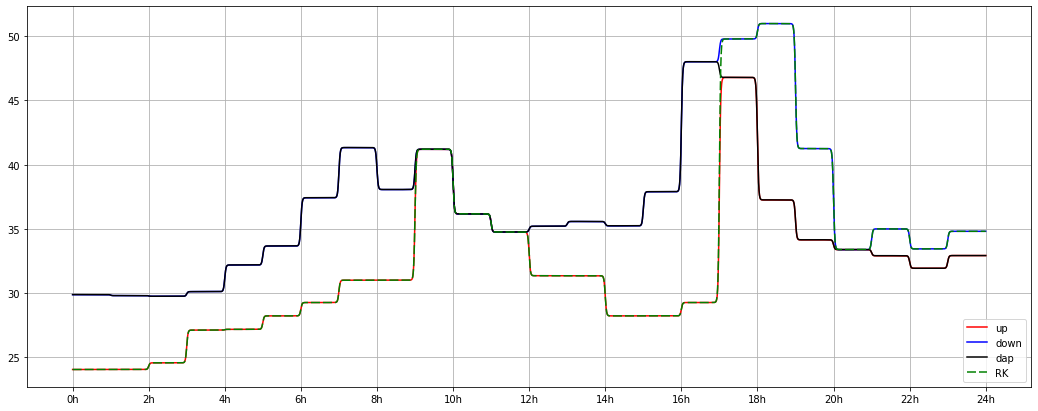

In [7]:
fig = plt.figure(figsize=(18,7))    
ax = fig.add_subplot(111)
ax.plot(T_price,smooth_dap(T_price,prices_plot['up']),color='red',label='up')
ax.plot(T_price,smooth_dap(T_price,prices_plot['down']),color='blue',label='down')
ax.plot(T_price,smooth_dap(T_price,prices_plot['spot']),color='black',label='dap')
ax.plot(T_price,smooth_dap(T_price,prices_plot['RK']),color='green',label='RK',dashes=[6, 2])
ax.set_xticks(np.arange(0,prices_plot['spot'].size+1,day_skip)*60.)
ax.set_xticklabels([str(int(_t/60.)) + 'h' for _t in np.arange(0,prices_plot['spot'].size+1,day_skip) * 60.])
ax.grid()
ax.legend(loc='lower right')
#plt.savefig(FIGS + '/control/example_regulation_price.pdf',format='pdf')

# Trajectory and price

In [8]:
# First order model
lambda_MELT = 0.00183*60
lambda_IDLE = 0.00085*60
mu_MELT = 66.92400 
mu_IDLE = 94.89100
sigma = 0.28130
R = 1.96580
pars = np.array([lambda_MELT, mu_MELT, lambda_IDLE, mu_IDLE, lambda_MELT, sigma, R])
m1 = firstordermodel(pars)
x0_1 = np.array([90.])


# Second order model
mu_IDLE = 957.10401120
mu_MELT = 700.74438030
omega_IDLE = 0.05220237
omega_MELT = 0.30504764
xi_IDLE = 0.18367929
xi_MELT = 0.50240445 
slope = 0.00778941
offset = 599.12794983
logsigma = np.array([-0.44650699, 2.53627662])
logR = -10.86389382

pars = np.array([mu_IDLE, mu_MELT, omega_IDLE, omega_MELT, xi_IDLE, xi_MELT, slope, offset, logsigma, logR])
m2 = secondordermodel(pars)
x0_2 = np.array([2.17082264, 873.03730756])

# Third order model
# Define model
mu_IDLE = 0.929224978
mu_MELT = 0.683920449 
a0_IDLE = 0.023590616
a0_MELT = 0.019370754
a1_IDLE = 0.867249723  
a1_MELT = 0.151822292
a2_IDLE = 46.261177791   
a2_MELT = 1.206710500
slow = 0.318488737 
logsigma = np.array([-5.110433517, -18.493395485,  -5.116712113])
logR = -8.444535962

pars = np.array([mu_IDLE, mu_MELT, a0_IDLE, a0_MELT, a1_IDLE, a1_MELT, a2_IDLE, a2_MELT, slow, logsigma, logR])
m3 = thirdordermodel(pars)
x0_3 = np.array([0.894357214,   0.007045742,  -0.360118853])

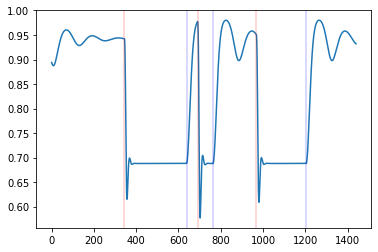

In [10]:
model = m2; x0 = x0_2
# Switches form Day Ahead
#np.random.seed(1240)
tf = 24 * 60
n_s = 3
switch_dap = np.sort(np.random.uniform(0,tf,2*n_s))
switch_dap = np.concatenate(derive_regimes(switch_dap,0,0))

# Switches from Regulation
switch_rk = np.sort(np.random.uniform(0,tf,2*n_s))
switch_rk = np.concatenate(derive_regimes(switch_rk,0,0))

dt = 0.01
T = dt * np.arange(0,int(tf/dt))
T_dap, X_dap, Z_dap = sol_ivp_wrapper_discrete(model,x0,switch_dap,tf,T)
T_rk, X_rk, Z_rk = sol_ivp_wrapper_discrete(model,x0,switch_rk,tf,T)

#plt.plot(T_dap, Z_dap[0])
#plotSwitches(switch_dap,plt)

plt.plot(T_rk, Z_rk[0])
plotSwitches(switch_rk,'r','b',plt)

In [11]:
# Expand f to also compute the consumptions
def f_with_consumption(t,x,switches,model,price,k_baseline,k_IDLE,k_MELT):
    
    # first nx-2 values is the state of the process
    # -2 value is the total power consumption
    # -1 is the total cost
    
    model_regime = smooth_regime(t,switches,1.)

    nx = x.size
    x_no_cost = x[:-1]
    dxdt_no_cost = model.f(t,x_no_cost,switches)
    dxdt = np.zeros(len(dxdt_no_cost)+1)

    # Normal process
    for i in range(nx-1):
        dxdt[i] = dxdt_no_cost[i]

    # Consumption
    dxdt[nx-1] = (k_baseline * model.h(x_no_cost) +  model_regime * k_MELT + (1-model_regime) * k_IDLE) * 1./60;   
    return(dxdt)

In [12]:
# Expand f to also compute the cost
def f_with_cost(t,x,switches,model,price,k_baseline,k_IDLE,k_MELT):
    
    # first nx-2 values is the state of the process
    # -2 value is the total power consumption
    # -1 is the total cost
    _price = smooth_dap(t,price)
    model_regime = smooth_regime(t,switches,1.)

    nx = x.size
    x_no_cost = x[:-2]
    dxdt_no_cost = model.f(t,x_no_cost,switches)
    dxdt = np.zeros(len(dxdt_no_cost)+2)

    # Normal process
    for i in range(nx-2):
        dxdt[i] = dxdt_no_cost[i]

    # Consumption
    dxdt[nx-2] = (k_baseline * model.h(x_no_cost) +  model_regime * k_MELT + (1-model_regime) * k_IDLE) * 1./60;
    # Cost
    dxdt[nx-1] = _price * (k_baseline * model.h(x_no_cost) +  model_regime * k_MELT + (1-model_regime) * k_IDLE) * 1./60.;   
    return(dxdt)

In [13]:
k_baseline = 12400.
k_MELT = 250.
k_IDLE = 9.
x0_cost = np.concatenate((x0,np.array([0.,0.])))
f_with_cost(0,x0_cost,switch_dap,model,prices_plot['spot'],k_baseline,k_IDLE,k_MELT)

array([-2.70718959e-01, -2.17082264e+00,  1.84935952e+02,  5.52408358e+03])

In [14]:
x0_consumption = np.append(x0,0)
f_with_consumption(0,x0_consumption,switch_dap,model,prices_plot['spot'],k_baseline,k_IDLE,k_MELT)

array([ -0.27071896,  -2.17082264, 184.9359516 ])

In [17]:
x0_cost = np.concatenate((x0,np.array([0.,0.])))
q = prices_plot['spot'] * 1e-6
#discrete_ivp_solver(f_with_cost,x0_cost,switch_dap,T,tf,extra_args=())
T_out, X_dap = discrete_ivp_solver(f_with_cost,x0_cost,switch_dap,T,tf,extra_args=(model,q,k_baseline,k_IDLE,k_MELT))
T_out, X_rk = discrete_ivp_solver(f_with_cost,x0_cost,switch_rk,T,tf,extra_args=(model,q,k_baseline,k_IDLE,k_MELT))

In [18]:
model.h(X_dap[:-2])[0]

array([0.89412555, 0.89410956, 0.89409358, ..., 0.91345502, 0.91347125,
       0.91348748])

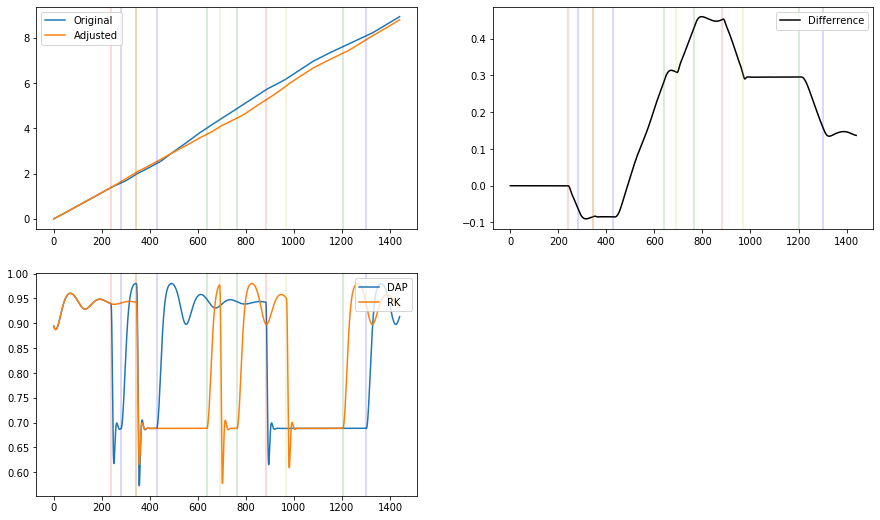

In [19]:
fig = plt.figure(figsize = (15,9))
ax1 = fig.add_subplot(221)

ax1.plot(T_out,X_dap[-1],label = "Original")
ax1.plot(T_out,X_rk[-1],label = "Adjusted")
plotSwitches(switch_dap,'r','b',ax1)
plotSwitches(switch_rk,'y','g',ax1)
ax1.legend(loc='upper left')


ax2 = fig.add_subplot(222)
ax2.plot(T_out,X_dap[-1] - X_rk[-1],label = "Differrence",color = 'black')
plotSwitches(switch_dap,'r','b',ax2)
plotSwitches(switch_rk,'y','g',ax2)
ax2.legend(loc='upper right')

ax3 = fig.add_subplot(223)
ax3.plot(T_out,model.h(X_dap[:-2])[0],label = "DAP")
ax3.plot(T_out,model.h(X_rk[:-2])[0],label = "RK")
plotSwitches(switch_dap,'r','b',ax3)
plotSwitches(switch_rk,'y','g',ax3)
ax3.legend(loc='upper right')

# Run for an hour and compute price
#### Asuming that if we by accident use more than DAH in up regulation, we have to pay the pricee for buying in what we need
Still need to take into account what happens due to the diffusion in the SDE

In [20]:
prices_sub = prices['2018-02-02  00:00:00':'2018-02-03  23:00:00']

In [26]:
number_of_hours = 10
dt = 0.01
model = m1; x0 = x0_1

tf = number_of_hours * 60
n_s = 5
np.random.seed(1234)
switch_dap = np.sort(np.random.uniform(0,tf,2*n_s))
switch_dap = np.concatenate(derive_regimes(switch_dap,0,0))

# Switches from Regulation
switch_rk = np.sort(np.random.uniform(0,tf,2*n_s))
switch_rk = np.concatenate(derive_regimes(switch_rk,0,0))

In [62]:
switches = np.concatenate((switch_dap,switch_rk))
full_return = 1
dt = 0.001
q_dap = prices_sub['spot'] * 1e-6
q_rk = prices_sub['RK'] * 1e-6
res = obj_rk(switches,number_of_hours,dt,model,x0,q_dap,q_rk,full_return)

Done


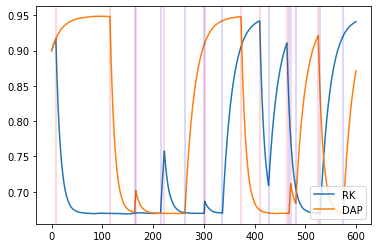

In [64]:
plt.plot(res['T'],model.h(res['X_rk'][:-1])[0],label = "RK")
plt.plot(res['T'],model.h(res['X_dap'][:-1])[0],label = "DAP")
plt.legend(loc = 'lower right')
plotSwitches(switch_dap,'r','b',plt)
plotSwitches(switch_rk,'r','b',plt)

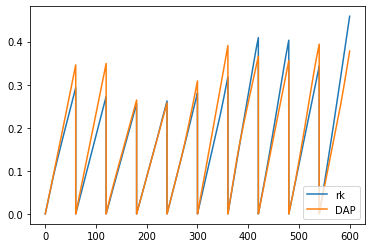

In [71]:
plt.plot(res['T'],res['total_price_regulated'],label = "rk")
plt.plot(res['T'],res['total_price_spot'],label = "DAP")
plt.legend(loc = 'lower right')

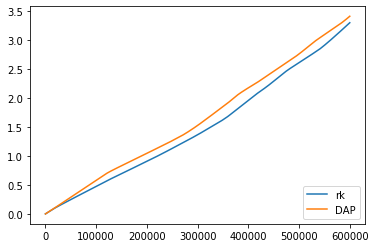

In [72]:
plt.plot(res['total_price_regulated_sum'],label = "rk")
plt.plot(res['total_price_spot_sum'],label = "DAP")
plt.legend(loc = 'lower right')

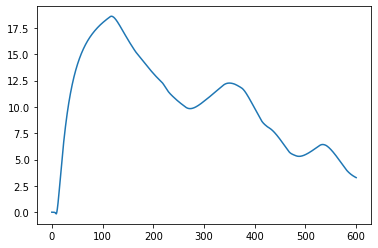

In [73]:
rel_diff = (res['total_price_spot_sum'][1:] - res['total_price_regulated_sum'][1:])/res['total_price_spot_sum'][1:]
plt.plot(res['T'][1:],rel_diff * 100)

In [74]:
dt = 0.001
full_return = 0
res_obj = obj(switches,number_of_hours,dt,model,x0,q_dap,q_rk,full_return)
res_obj

3.2990481873135584

In [75]:
dt = 0.0001
full_return = 0
res_obj = obj(switches,number_of_hours,dt,model,x0,q_dap,q_rk,full_return)
res_obj

3.2991247853924497

# Build constraints and optimize

In [76]:
number_of_hours = 10
dt = 0.0001
model = m1; x0 = x0_1
n_s = 5
max_melt = 60 * 9

tf = number_of_hours * 60

In [77]:
idle = tf * np.linspace(0.1,0.9,n_s) # Spread out on the whole interval
melt = idle - max_melt/n_s * 0.2 # Assign melt period to a little before idle
switch0_dap = np.concatenate((melt,idle)) # put together

idle = tf * np.linspace(0.05,0.85,n_s) # Spread out on the whole interval
melt = idle - max_melt/n_s * 0.2 # Assign melt period to a little before idle
switch0_rk = np.concatenate((melt,idle)) # put together

switch0 = np.concatenate((switch0_dap,switch0_rk))
switch0

array([ 38.4, 158.4, 278.4, 398.4, 518.4,  60. , 180. , 300. , 420. ,
       540. ,   8.4, 128.4, 248.4, 368.4, 488.4,  30. , 150. , 270. ,
       390. , 510. ])

# Build switch constraints on both dap and rk
Basically, reapeat the same on another block

In [78]:
from scipy.optimize import Bounds

n_constraints = 2*2*n_s
bounds = Bounds(np.zeros(n_constraints), tf * np.ones(n_constraints))

A = constraintASparse(n_s).toarray()
lwb_lin = np.full(n_constraints, -np.inf)
upb_lin = np.full(n_constraints, 0)
upb_lin[2*n_s-1] = max_melt
upb_lin[-1] = max_melt
linear_constraint = sc_opt.LinearConstraint(A, -np.inf, 0,keep_feasible=True)

In [79]:
full_return = 0
dt = 0.001
res = obj(switch0,number_of_hours,dt,model,x0,q_dap,q_rk,full_return)
res

3.756637668034797

In [80]:
(lwb_lin < A.dot(switch0)) & (A.dot(switch0) < upb_lin)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [81]:
A.dot(switch0)

array([-21.6, -21.6, -21.6, -21.6, -21.6, -98.4, -98.4, -98.4, -98.4,
       108. , -21.6, -21.6, -21.6, -21.6, -21.6, -98.4, -98.4, -98.4,
       -98.4, 108. ])

In [82]:
# No gradients
res_nograd = sc_opt.minimize(obj, switch0, args=(number_of_hours,dt,model,x0,q_dap,q_rk,full_return),\
                             method='trust-constr',constraints=linear_constraint, bounds=bounds,\
                             options={'gtol': 1e-8, 'xtol': 1e-8, 'disp': True,\
                             'initial_tr_radius' : 10,'maxiter': 100})


ValueError: `x0` is infeasible with respect to some inequality constraint with `keep_feasible` set to True.

In [ ]:
switch_dap = np.array([  46.83377898 ,167.34974525, 287.42127013 ,407.23173924 ,527.34335194,
  50.33940248, 167.9041169 , 288.89252523, 408.42068181, 529.37043783 ])
switch_rk = np.array([ 11.7061039 , 126.66850655, 250.19497331, 371.23021996 ,491.78856195,
  19.59906399, 126.01136145 ,251.17996141, 373.32271455, 494.32774581])
switch_test = np.concatenate((switch_dap,switch_rk))

In [ ]:
(lwb_lin < A.dot(switch_test)) & (A.dot(switch_test) < upb_lin)

In [ ]:
res = obj(switch_test,number_of_hours,dt,model,x0,full_return)

In [ ]:
# PLOT OBJEC FUNCTION
plot = False
    if plot:
        fig = plt.figure(figsize = (15,9))
        ax1 = fig.add_subplot(231)

        ax1.plot(T_hour,X_dap[-2],label = "DAP - consumption")
        ax1.plot(T_hour,X_rk[-2],label = "RK - consumption")
        plotSwitches(switch_dap,'r','b',ax1)
        plotSwitches(switch_rk,'y','g',ax1)
        plt.xlim(T_hour[0], T_hour[-1])
        ax1.legend(loc='upper left')


        ax2 = fig.add_subplot(232)
        ax2.plot(T_hour,X_rk[-2] - X_dap[-2],label = "Accumulated Differrence in consumption",color = 'black')
        plotSwitches(switch_dap,'r','b',ax2)
        plotSwitches(switch_rk,'y','g',ax2)
        plt.xlim(T_hour[0], T_hour[-1])
        ax2.legend(loc='upper right')

        ax3 = fig.add_subplot(233)
        ax3.plot(T_hour,model.h(X_dap[:-2])[0],label = "DAP")
        ax3.plot(T_hour,model.h(X_rk[:-2])[0],label = "RK")
        plotSwitches(switch_dap,'r','b',ax3)
        plotSwitches(switch_rk,'y','g',ax3)
        plt.xlim(T_hour[0], T_hour[-1])
        plt.ylim(0.4, 1.1)
        ax3.legend(loc='upper right')

        ax4 = fig.add_subplot(234)
        ax4.plot(T_hour,smooth_dap(T_hour,q_dap),label = "DAP")
        ax4.plot(T_hour,smooth_dap(T_hour,q_rk),label = "RK")
        plotSwitches(switch_dap,'r','b',ax4)
        plotSwitches(switch_rk,'y','g',ax4)
        plt.xlim(T_hour[0], T_hour[-1])
        ax4.legend(loc='upper right')

        ax5 = fig.add_subplot(235)
        ax5.plot(total_rk_price,label='RK price')
        ax5.plot(total_spot_price,label='Spot price')
        ax5.legend()

In [ ]:
switches = switch0
dt = 0.001

In [ ]:

    
n_s = int(len(switches)/4)
switch_dap = switches[:(2*n_s)]
switch_rk = switches[(2*n_s):]
#print(switch_dap)
#print(switch_rk)


assert (number_of_hours <= int(prices_sub['RK'].size)), 'Too short price array'

# Extract variables from input
n_obs = int(number_of_hours * 60/dt)
#print(n_obs)
q_dap = prices_sub['spot'] * 1e-6
q_rk = prices_sub['RK'] * 1e-6
tf = 60 * number_of_hours

# Prepare variables
x0_consumption_dap = np.concatenate((x0,np.array([0.])))
x0_consumption_rk = np.concatenate((x0,np.array([0.])))

nx = x0_cost_rk.size
T_out = np.zeros((n_obs))
total_price_regulated = np.zeros((n_obs))
total_price_spot = np.zeros((n_obs))
total_price_regulated_sum = np.zeros((n_obs))
total_price_spot_sum = np.zeros((n_obs))

X_out_dap = np.zeros((nx,n_obs))
X_out_rk = np.zeros((nx,n_obs))

current_acc_spot_price = 0.
current_acc_rk_price = 0.


for hour in range(number_of_hours):
    #print(current_acc_rk_price)
    #print(current_acc_spot_price)


    print(hour)
    # Takes 0.2 second to execute the solvers for dt = 0.001
    # Run for 60 minutes in hour x
    T = hour * 60 + dt * np.arange(0,int(60/dt))
    #print(T)
    T_hour, X_dap = discrete_ivp_solver(f_with_consumption,x0_consumption_dap,switch_dap,T,tf,extra_args=(model,q_dap,k_baseline,k_IDLE,k_MELT))
    T_hour, X_rk = discrete_ivp_solver(f_with_consumption,x0_consumption_rk,switch_rk,T,tf,extra_args=(model,q_rk,k_baseline,k_IDLE,k_MELT))
    #sol_dap = solve_ivp(f_with_cost, [T[0], T[-1]], x0_cost, args=(model,q_dap,switch_dap,k,k_IDLE,k_MELT),t_eval=T)
    #sol_rk = solve_ivp(f_with_cost, [T[0], T[-1]], x0_cost, args=(model,q_rk,switch_rk,k,k_IDLE,k_MELT),t_eval=T)

    x0_consumption_dap = np.concatenate(([X_dap[i][-1] for i in range(X_dap.shape[0]-1)], np.array([0.])))
    x0_consumption_rk = np.concatenate(([X_rk[i][-1] for i in range(X_rk.shape[0]-1)], np.array([0.])))



    #print(X_dap[-1][-1])
    #print(X_rk[-1][-1])

    # Expected use
    #exp_use = X_dap[-2]

    # Difference from expected
    #diff_use = X_rk[-2] - X_dap[-2]

    total_rk_price = (X_rk[-1] - X_dap[-1]) * q_rk[hour] +  (X_dap[-1]) * q_dap[hour]
    total_spot_price = X_dap[-1] * q_dap[hour]

    # Save values
    idx = np.array(range(0,int(60/dt))) + hour * int(60/dt)
    #print('Index',idx)
    T_out[idx] = T_hour
    X_out_dap[:,idx] = X_dap
    X_out_rk[:,idx] = X_rk

    # Save all accumulated prices for this very hour
    total_price_regulated[idx] = total_rk_price
    total_price_spot[idx] = total_spot_price

    # Save all accumulated prices for after hour
    total_price_regulated_sum[idx] = total_rk_price + current_acc_rk_price
    total_price_spot_sum[idx] = total_spot_price + current_acc_spot_price

    # Update current accumulated price
    current_acc_rk_price = total_price_regulated_sum[idx[-1]]
    current_acc_spot_price = total_price_spot_sum[idx[-1]]  

        #print(100 * ((total_rk_price - total_spot_price)[-1]) / total_spot_price[-1])



In [ ]:
T = hour * 60 + dt * np.arange(0,int(60/dt))
T.size

In [ ]:
T_hour, X_dap = discrete_ivp_solver(f_with_consumption,x0_consumption_dap,switch_dap,T,tf,extra_args=(model,q_dap,k_baseline,k_IDLE,k_MELT))



In [ ]:
T_hour, X_dap = discrete_ivp_solver(f_with_consumption,x0_consumption_dap,switch_rk,T,tf,extra_args=(model,q_dap,k_baseline,k_IDLE,k_MELT))



In [ ]:
switch_rk, switch_dap